In [1]:
import os
import parse
import pickle

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import dionysus as dion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
import sklearn
import networkx as nx
from grakel import GraphKernel
import grakel
import seaborn as sns

from pt_activation.models.simple_mnist import CFF

%load_ext autoreload
%autoreload 2

In [2]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret
    

In [3]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/gaussian_blur/cff_5-filters_5-kernel_size_50-fc1_relu-activation.pt/90'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [4]:
def create_filtrations(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                row = {'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0], 'sample':t+s}
                res_df.append(row)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df)


def create_adversary_filtrations(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = []
    adv_labels = []
    adv_samples = []
    missed = []
    for a in adversaries:
        if a['adversary'].shape != ():
            adv_images.append(a['adversary'])
            adv_labels.append(a['true class'])
            adv_samples.append(a['sample'])
        else:
            missed.append(a['sample'])
    adv_images = torch.tensor(np.array(adv_images))
    adv_labels = torch.tensor(np.array(adv_labels))
    
    print(adv_images.shape, adv_labels.shape)
    
    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                row = {'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0], 'sample':adv_samples[t+s]}
                res_df.append(row)

            t += (batch_size)
            if t >= up_to:
                break
    print(missed)
    return pd.DataFrame(res_df)

def create_filtrations(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f = model.compute_dynamic_filtration(data[s,0], this_hiddens)
                #
                row = {'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df)


def create_adversary_filtrations(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = []
    adv_labels = []
    missed = []
    for a in adversaries:
        if a['adversary'].shape != ():
            adv_images.append(a['adversary'])
            adv_labels.append(a['true class'])
        else:
            missed.append(a)
    adv_images = torch.tensor(np.array(adv_images))
    adv_labels = torch.tensor(np.array(adv_labels))
    
    print(adv_images.shape, adv_labels.shape)
    
    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f = model.compute_dynamic_filtration(data[s,0], this_hiddens)
                #
                row = {'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)

            t += batch_size
            if t >= up_to:
                break
    print(missed)
    return pd.DataFrame(res_df)

In [5]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/cff_5-filters_5-kernel_size_50-fc1_relu-activation.pt'
model = CFF()
model.load_state_dict(torch.load(model_location))

In [6]:
adv_df = create_adversary_filtrations(model, 50, 1000, adversaries)

torch.Size([9995, 1, 28, 28]) torch.Size([9995])
[]


In [7]:
res_df = create_filtrations(model, 50, 1000)

In [8]:
adv_df.head(20)

,class,loss,prediction,sample
0,7,-2.938572,3,0
1,2,-2.838409,8,1
2,1,-2.518164,8,2
3,0,-1.808645,8,3
4,4,-2.812756,9,4
5,1,-2.632296,3,5
6,4,-5.712584,8,6
7,9,-2.575851,3,7
8,5,-3.320119,8,8
9,9,-2.827274,8,9


In [9]:
res_df.head(20)

,class,loss,prediction,sample
0,7,-5.852718,7,0
1,2,-4.867386,2,1
2,1,-4.052566,1,2
3,0,-0.165271,0,3
4,4,-4.754526,4,4
5,1,-4.986809,1,5
6,4,-6.690396,4,6
7,9,-5.546339,9,7
8,5,-5.397768,5,8
9,9,-6.542599,9,9


In [10]:
def create_sample_graphs(df):
    sample_graphs = []
    for s in range(df.shape[0]):
        print(s)
        subgraphs = {}
        f = df['filtration'].iloc[s]
        m = dion.homology_persistence(f)
        dgms = dion.init_diagrams(m,f)
        for i,c in enumerate(m):
            if len(c) == 2:
                if f[c[0].index][0] in subgraphs:
                    subgraphs[f[c[0].index][0]].add_edge(f[c[0].index][0],f[c[1].index][0],weight=f[i].data)
                else:
                    eaten = False
                    for k, v in subgraphs.items():
                        if v.has_node(f[c[0].index][0]):
                            v.add_edge(f[c[0].index][0], f[c[1].index][0], weight=f[i].data)
                            eaten = True
                            break
                    if not eaten:
                        g = nx.Graph()
                        g.add_edge(f[c[0].index][0], f[c[1].index][0], weight=f[i].data)
                        subgraphs[f[c[0].index][0]] = g

        sample_graphs.append(subgraphs)
    return sample_graphs

In [11]:
# adv_sample_graphs = create_sample_graphs(adv_df)
# with open(os.path.join(adv_directory_loc, 'adv_samples.pkl'), 'wb') as f:
#     pickle.dump(adv_sample_graphs, f)
# sample_graphs = create_sample_graphs(res_df)
# with open(os.path.join(adv_directory_loc, 'samples.pkl'), 'wb') as f:
#     pickle.dump(sample_graphs, f)

sample_graphs = pickle.load( open(os.path.join('/home/tgebhart/projects/pt_activation/logdir/adversaries/additive_gaussian_noise/cff_5-filters_5-kernel_size_50-fc1_relu-activation.pt/90', 'samples.pkl'), "rb") )
adv_sample_graphs = pickle.load( open(os.path.join(adv_directory_loc, 'adv_samples.pkl'), "rb") )

In [ ]:
# options = {
#     'node_color': 'red',
#     'node_size': 2,
#     'width': 3,
#     'with_labels':True}
# nx.draw_random(subgraphs[243], **options)

In [12]:
COLORS = ['#12355b', '#ff6978']
EDGE_COLOR = '#272d2d'
PLT_LABELS = ['Unaltered', 'Adversarial']
# COLORS = ['#bfdce7', '#ff6978']

In [13]:
sgl = np.zeros(len(sample_graphs))
for i in range(len(sample_graphs)):
    sgl[i] = len(sample_graphs[i])

adv_sgl = np.zeros(len(adv_sample_graphs))
for i in range(len(adv_sample_graphs)):
    adv_sgl[i] = len(adv_sample_graphs[i])


Text(0.5, 0, 'Number of Generators')

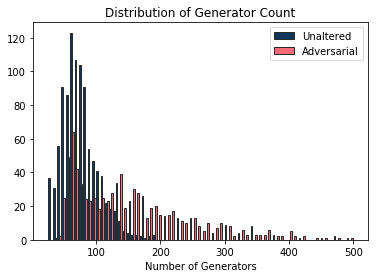

In [14]:
plt.hist([sgl, adv_sgl], bins='auto', range=[25,500], color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Generator Count')
plt.xlabel('Number of Generators')

In [ ]:
take = 10
edges = set()
for i in range(len(sample_graphs)):
    for k in list(sample_graphs[i].keys())[:take]:
        for x in sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edges.add(edge_name)

In [ ]:
for i in range(len(adv_sample_graphs)):
    for k in list(adv_sample_graphs[i].keys())[:take]:
        for x in adv_sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edges.add(edge_name)

In [ ]:
edf = pd.DataFrame(np.zeros((len(sample_graphs)+len(adv_sample_graphs),len(edges))), columns=list(edges))
for i in range(len(sample_graphs)):
    print('Sample: {}/{}'.format(i,len(sample_graphs)))
    for k in list(sample_graphs[i].keys())[:take]:
        for x in sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edf.iloc[i][edge_name] = x[2]['weight']
            
for i in range(len(adv_sample_graphs)):
    print('Sample: {}/{}'.format(i,len(adv_sample_graphs)))
    for k in list(adv_sample_graphs[i].keys())[:take]:
        for x in adv_sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edf.iloc[i+len(sample_graphs)][edge_name] = x[2]['weight']

            

In [ ]:
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
scaled = min_max_scaler.fit_transform(np.concatenate((sgl, adv_sgl), axis=0).reshape(-1,1))
edf['graph counts'] = pd.Series(scaled.T.reshape(-1), index=edf.index)

In [ ]:
edf.tail()

In [ ]:
X = edf.values[:len(sample_graphs)]
y = res_df['class'].values

In [ ]:
clf = svm.SVC(gamma='scale', decision_function_shape='ovo').fit(X,y)

In [ ]:
X_adv = edf.values[len(sample_graphs):]
adv_preds = clf.predict(X_adv)

In [ ]:
sklearn.metrics.accuracy_score(adv_df['class'], adv_preds)

In [ ]:
adv_preds[:10]

In [ ]:
adv_df.head(10)

In [ ]:
sklearn.metrics.accuracy_score(adv_df['prediction'], adv_preds)

In [ ]:
clf2 = svm.SVC(gamma='scale', decision_function_shape='ovo').fit(X[:-100],y[:-100])

In [ ]:
sklearn.metrics.accuracy_score(y[-100:], clf2.predict(X[-100:]))

In [15]:
all_gois = []
for i in range(len(sample_graphs)):
    print(i)
    a = [sample_graphs[i][k] for k in sample_graphs[i].keys()]
    all_gois.append(nx.compose_all(a))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [16]:
adv_all_gois = []
for i in range(len(adv_sample_graphs)):
    print(i)
    a = [adv_sample_graphs[i][k] for k in adv_sample_graphs[i].keys()]
    adv_all_gois.append(nx.compose_all(a))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [17]:
eigs = []
for i in range(len(all_gois)):
    print('normal ', i)
    eigs.append(nx.linalg.laplacian_spectrum(all_gois[i]))

adv_eigs = []
for i in range(len(adv_all_gois)):
    print('adv ', i)
    adv_eigs.append(nx.linalg.laplacian_spectrum(adv_all_gois[i]))

normal  0
normal  1
normal  2
normal  3
normal  4
normal  5
normal  6
normal  7
normal  8
normal  9
normal  10
normal  11
normal  12
normal  13
normal  14
normal  15
normal  16
normal  17
normal  18
normal  19
normal  20
normal  21
normal  22
normal  23
normal  24
normal  25
normal  26
normal  27
normal  28
normal  29
normal  30
normal  31
normal  32
normal  33
normal  34
normal  35
normal  36
normal  37
normal  38
normal  39
normal  40
normal  41
normal  42
normal  43
normal  44
normal  45
normal  46
normal  47
normal  48
normal  49
normal  50
normal  51
normal  52
normal  53
normal  54
normal  55
normal  56
normal  57
normal  58
normal  59
normal  60
normal  61
normal  62
normal  63
normal  64
normal  65
normal  66
normal  67
normal  68
normal  69
normal  70
normal  71
normal  72
normal  73
normal  74
normal  75
normal  76
normal  77
normal  78
normal  79
normal  80
normal  81
normal  82
normal  83
normal  84
normal  85
normal  86
normal  87
normal  88
normal  89
normal  90
normal  9

normal  692
normal  693
normal  694
normal  695
normal  696
normal  697
normal  698
normal  699
normal  700
normal  701
normal  702
normal  703
normal  704
normal  705
normal  706
normal  707
normal  708
normal  709
normal  710
normal  711
normal  712
normal  713
normal  714
normal  715
normal  716
normal  717
normal  718
normal  719
normal  720
normal  721
normal  722
normal  723
normal  724
normal  725
normal  726
normal  727
normal  728
normal  729
normal  730
normal  731
normal  732
normal  733
normal  734
normal  735
normal  736
normal  737
normal  738
normal  739
normal  740
normal  741
normal  742
normal  743
normal  744
normal  745
normal  746
normal  747
normal  748
normal  749
normal  750
normal  751
normal  752
normal  753
normal  754
normal  755
normal  756
normal  757
normal  758
normal  759
normal  760
normal  761
normal  762
normal  763
normal  764
normal  765
normal  766
normal  767
normal  768
normal  769
normal  770
normal  771
normal  772
normal  773
normal  774
norm

adv  512
adv  513
adv  514
adv  515
adv  516
adv  517
adv  518
adv  519
adv  520
adv  521
adv  522
adv  523
adv  524
adv  525
adv  526
adv  527
adv  528
adv  529
adv  530
adv  531
adv  532
adv  533
adv  534
adv  535
adv  536
adv  537
adv  538
adv  539
adv  540
adv  541
adv  542
adv  543
adv  544
adv  545
adv  546
adv  547
adv  548
adv  549
adv  550
adv  551
adv  552
adv  553
adv  554
adv  555
adv  556
adv  557
adv  558
adv  559
adv  560
adv  561
adv  562
adv  563
adv  564
adv  565
adv  566
adv  567
adv  568
adv  569
adv  570
adv  571
adv  572
adv  573
adv  574
adv  575
adv  576
adv  577
adv  578
adv  579
adv  580
adv  581
adv  582
adv  583
adv  584
adv  585
adv  586
adv  587
adv  588
adv  589
adv  590
adv  591
adv  592
adv  593
adv  594
adv  595
adv  596
adv  597
adv  598
adv  599
adv  600
adv  601
adv  602
adv  603
adv  604
adv  605
adv  606
adv  607
adv  608
adv  609
adv  610
adv  611
adv  612
adv  613
adv  614
adv  615
adv  616
adv  617
adv  618
adv  619
adv  620
adv  621
adv  622
a

In [18]:
num_top_eigs = 800
top_eigs = np.zeros((len(eigs),num_top_eigs))
for i in range(len(eigs)):
#     top_eigs[i] = np.sort(eigs[i])[::-1][:num_top_eigs] # descending
    top_eigs[i] = np.sort(eigs[i])[:num_top_eigs] # ascending
    
adv_top_eigs = np.zeros((len(adv_eigs),num_top_eigs))
for i in range(len(adv_eigs)):
#     adv_top_eigs[i] = np.sort(adv_eigs[i])[::-1][:num_top_eigs] # descending
    adv_top_eigs[i] = np.sort(adv_eigs[i])[:num_top_eigs] # ascending

Text(0.5, 1.0, 'Distribution of Maximum Eigenvalue of Spectrum')

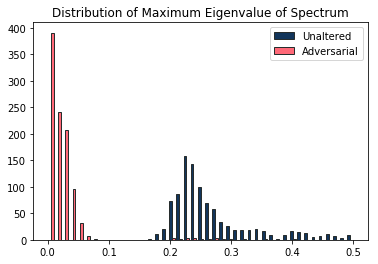

In [19]:
plt.hist([np.amax(top_eigs, axis=1),np.amax(adv_top_eigs, axis=1)], range=[0,.5], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Maximum Eigenvalue of Spectrum')

Text(0.5, 1.0, 'Distribution of Mean Eigenvalue of Spectrum')

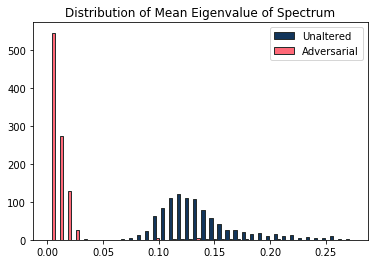

In [20]:
plt.hist([np.mean(top_eigs, axis=1),np.mean(adv_top_eigs, axis=1)], range=[0,.275], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Mean Eigenvalue of Spectrum')

Text(0.5, 1.0, 'Distribution of Median Eigenvalue of Spectrum')

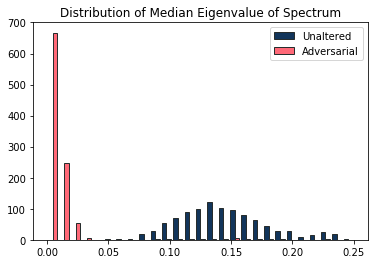

In [21]:
plt.hist([np.median(top_eigs, axis=1),np.median(adv_top_eigs, axis=1)], range=[0,.25], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Median Eigenvalue of Spectrum')

Text(0.5, 1.0, 'Distribution of Minimum Eigenvalue of Spectrum')

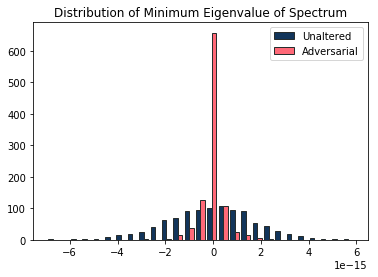

In [22]:
plt.hist([np.amin(top_eigs, axis=1),np.amin(adv_top_eigs, axis=1)], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Minimum Eigenvalue of Spectrum')

Text(0, 0.5, 'Probability')

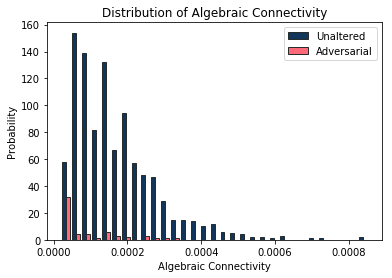

In [23]:
plt.hist([top_eigs[:,1], adv_top_eigs[:,1]], bins='auto',color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Algebraic Connectivity')
plt.xlabel('Algebraic Connectivity')
plt.ylabel('Probability')

In [24]:
mean_eigs = np.zeros((len(eigs),3))
for i in range(len(eigs)):
    mean_eigs[i] = [eigs[i].mean(), eigs[i].shape[0], np.median(eigs[i])]
    
adv_mean_eigs = np.zeros((len(adv_eigs),3))
for i in range(len(adv_eigs)):
    adv_mean_eigs[i] = [adv_eigs[i].mean(), adv_eigs[i].shape[0], np.median(adv_eigs[i])]

Text(0.5, 1.0, 'Distribution of Mean Eigenvalues of Spectrum')

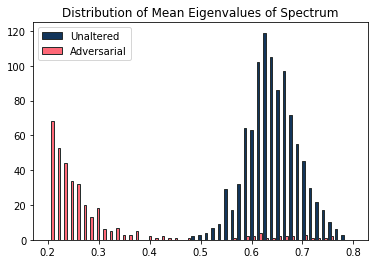

In [25]:
plt.hist([mean_eigs[:,0], adv_mean_eigs[:,0]], range=[0.2,0.8], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Mean Eigenvalues of Spectrum')

Text(0.5, 1.0, 'Distribution of Median Eigenvalues of Spectrum')

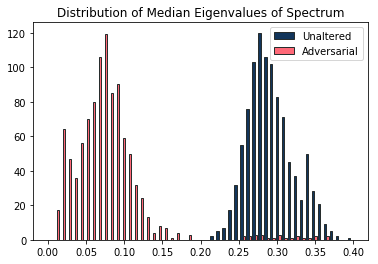

In [26]:
plt.hist([mean_eigs[:,2], adv_mean_eigs[:,2]], range=[0,0.4], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Median Eigenvalues of Spectrum')

Text(0.5, 1.0, 'Distribution of Spectrum Size')

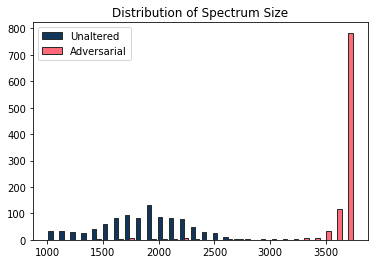

In [27]:
plt.hist([mean_eigs[:,1], adv_mean_eigs[:,1]], range=[1000,3750], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Spectrum Size')

In [28]:
some_num = 10
some_gois = []
for i in range(len(sample_graphs)):
    print(i)
    sgik = list(sample_graphs[i].keys())
    a = [sample_graphs[i][k] for k in sgik[len(sgik)-some_num:]]
    some_gois.append(nx.compose_all(a))
    
adv_some_gois = []
for i in range(len(adv_sample_graphs)):
    print(i)
    sgik = list(adv_sample_graphs[i].keys())
    a = [adv_sample_graphs[i][k] for k in sgik[len(sgik)-some_num:]]
    adv_some_gois.append(nx.compose_all(a))
    
some_eigs = []
for i in range(len(some_gois)):
    print('normal ', i)
    some_eigs.append(nx.linalg.laplacian_spectrum(some_gois[i]))

adv_some_eigs = []
for i in range(len(adv_some_gois)):
    print('adv ', i)
    adv_some_eigs.append(nx.linalg.laplacian_spectrum(adv_some_gois[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

normal  48
normal  49
normal  50
normal  51
normal  52
normal  53
normal  54
normal  55
normal  56
normal  57
normal  58
normal  59
normal  60
normal  61
normal  62
normal  63
normal  64
normal  65
normal  66
normal  67
normal  68
normal  69
normal  70
normal  71
normal  72
normal  73
normal  74
normal  75
normal  76
normal  77
normal  78
normal  79
normal  80
normal  81
normal  82
normal  83
normal  84
normal  85
normal  86
normal  87
normal  88
normal  89
normal  90
normal  91
normal  92
normal  93
normal  94
normal  95
normal  96
normal  97
normal  98
normal  99
normal  100
normal  101
normal  102
normal  103
normal  104
normal  105
normal  106
normal  107
normal  108
normal  109
normal  110
normal  111
normal  112
normal  113
normal  114
normal  115
normal  116
normal  117
normal  118
normal  119
normal  120
normal  121
normal  122
normal  123
normal  124
normal  125
normal  126
normal  127
normal  128
normal  129
normal  130
normal  131
normal  132
normal  133
normal  134
normal  

normal  792
normal  793
normal  794
normal  795
normal  796
normal  797
normal  798
normal  799
normal  800
normal  801
normal  802
normal  803
normal  804
normal  805
normal  806
normal  807
normal  808
normal  809
normal  810
normal  811
normal  812
normal  813
normal  814
normal  815
normal  816
normal  817
normal  818
normal  819
normal  820
normal  821
normal  822
normal  823
normal  824
normal  825
normal  826
normal  827
normal  828
normal  829
normal  830
normal  831
normal  832
normal  833
normal  834
normal  835
normal  836
normal  837
normal  838
normal  839
normal  840
normal  841
normal  842
normal  843
normal  844
normal  845
normal  846
normal  847
normal  848
normal  849
normal  850
normal  851
normal  852
normal  853
normal  854
normal  855
normal  856
normal  857
normal  858
normal  859
normal  860
normal  861
normal  862
normal  863
normal  864
normal  865
normal  866
normal  867
normal  868
normal  869
normal  870
normal  871
normal  872
normal  873
normal  874
norm

adv  650
adv  651
adv  652
adv  653
adv  654
adv  655
adv  656
adv  657
adv  658
adv  659
adv  660
adv  661
adv  662
adv  663
adv  664
adv  665
adv  666
adv  667
adv  668
adv  669
adv  670
adv  671
adv  672
adv  673
adv  674
adv  675
adv  676
adv  677
adv  678
adv  679
adv  680
adv  681
adv  682
adv  683
adv  684
adv  685
adv  686
adv  687
adv  688
adv  689
adv  690
adv  691
adv  692
adv  693
adv  694
adv  695
adv  696
adv  697
adv  698
adv  699
adv  700
adv  701
adv  702
adv  703
adv  704
adv  705
adv  706
adv  707
adv  708
adv  709
adv  710
adv  711
adv  712
adv  713
adv  714
adv  715
adv  716
adv  717
adv  718
adv  719
adv  720
adv  721
adv  722
adv  723
adv  724
adv  725
adv  726
adv  727
adv  728
adv  729
adv  730
adv  731
adv  732
adv  733
adv  734
adv  735
adv  736
adv  737
adv  738
adv  739
adv  740
adv  741
adv  742
adv  743
adv  744
adv  745
adv  746
adv  747
adv  748
adv  749
adv  750
adv  751
adv  752
adv  753
adv  754
adv  755
adv  756
adv  757
adv  758
adv  759
adv  760
a

In [29]:
some_mean_eigs = np.zeros((len(some_eigs),5))
for i in range(len(some_eigs)):
    some_mean_eigs[i] = [some_eigs[i].mean(), some_eigs[i].shape[0], np.median(some_eigs[i]), some_eigs[i].min(), some_eigs[i].max()]
    
adv_some_mean_eigs = np.zeros((len(adv_some_eigs),5))
for i in range(len(adv_some_eigs)):
    adv_some_mean_eigs[i] = [adv_some_eigs[i].mean(), adv_some_eigs[i].shape[0], np.median(adv_some_eigs[i]), adv_some_eigs[i].min(), adv_some_eigs[i].max()]

Text(0.5, 1.0, 'Distribution of Mean Eigenvalues of Spectrum')

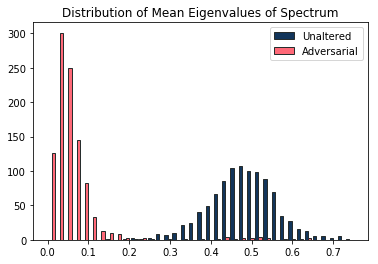

In [30]:
plt.hist([some_mean_eigs[:,0], adv_some_mean_eigs[:,0]], range=[0,0.75], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Mean Eigenvalues of Spectrum')

Text(0.5, 1.0, 'Distribution of Median Eigenvalues of Spectrum')

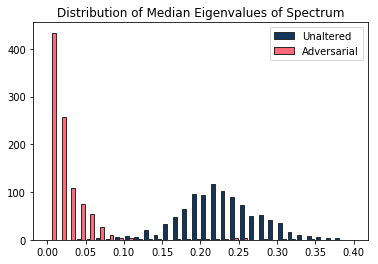

In [31]:
plt.hist([some_mean_eigs[:,2], adv_some_mean_eigs[:,2]], range=[0,0.4], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Median Eigenvalues of Spectrum')

Text(0.5, 1.0, 'Distribution of Spectrum Size')

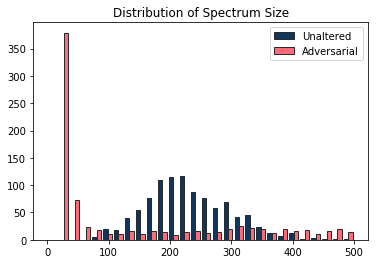

In [32]:
plt.hist([some_mean_eigs[:,1], adv_some_mean_eigs[:,1]], range=[0,500], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Spectrum Size')

Text(0.5, 1.0, 'Distribution of Minimum Eigenvalue of Spectrum')

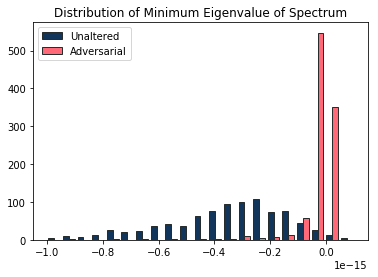

In [33]:
plt.hist([some_mean_eigs[:,3], adv_some_mean_eigs[:,3]], range=[-1e-15,1e-16], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Minimum Eigenvalue of Spectrum')

Text(0.5, 1.0, 'Distribution of Maximum Eigenvalue of Spectrum')

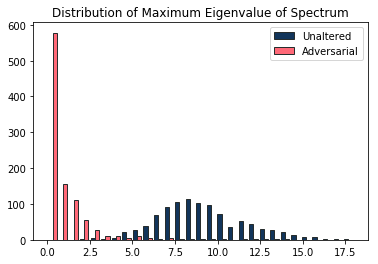

In [34]:
plt.hist([some_mean_eigs[:,4], adv_some_mean_eigs[:,4]], range=[0,18], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Maximum Eigenvalue of Spectrum')

/home/tgebhart/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


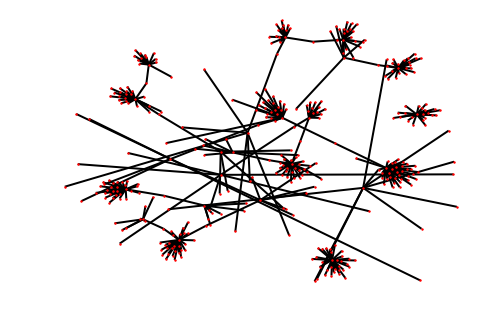

In [35]:
options = {
    'node_color': 'red',
    'node_size': 2,
    'width': 2,
    'with_labels':False}
nx.draw_spring(some_gois[2], **options)

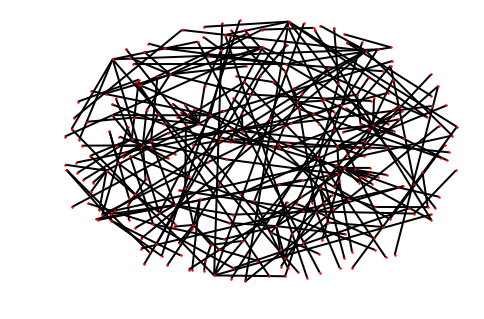

In [36]:
options = {
    'node_color': 'red',
    'node_size': 2,
    'width': 2,
    'with_labels':False}
nx.draw_spring(adv_some_gois[2], **options)

In [37]:
some_num = 10
some_gois = []
for i in range(len(sample_graphs)):
    print(i)
    sgik = list(sample_graphs[i].keys())
    a = [sample_graphs[i][k] for k in sgik[:some_num]]
    some_gois.append(nx.compose_all(a))
    
adv_some_gois = []
for i in range(len(adv_sample_graphs)):
    print(i)
    sgik = list(adv_sample_graphs[i].keys())
    a = [adv_sample_graphs[i][k] for k in sgik[:some_num]]
    adv_some_gois.append(nx.compose_all(a))
    
some_eigs = []
for i in range(len(some_gois)):
    print('normal ', i)
    some_eigs.append(nx.linalg.laplacian_spectrum(some_gois[i]))

adv_some_eigs = []
for i in range(len(adv_some_gois)):
    print('adv ', i)
    adv_some_eigs.append(nx.linalg.laplacian_spectrum(adv_some_gois[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

normal  53
normal  54
normal  55
normal  56
normal  57
normal  58
normal  59
normal  60
normal  61
normal  62
normal  63
normal  64
normal  65
normal  66
normal  67
normal  68
normal  69
normal  70
normal  71
normal  72
normal  73
normal  74
normal  75
normal  76
normal  77
normal  78
normal  79
normal  80
normal  81
normal  82
normal  83
normal  84
normal  85
normal  86
normal  87
normal  88
normal  89
normal  90
normal  91
normal  92
normal  93
normal  94
normal  95
normal  96
normal  97
normal  98
normal  99
normal  100
normal  101
normal  102
normal  103
normal  104
normal  105
normal  106
normal  107
normal  108
normal  109
normal  110
normal  111
normal  112
normal  113
normal  114
normal  115
normal  116
normal  117
normal  118
normal  119
normal  120
normal  121
normal  122
normal  123
normal  124
normal  125
normal  126
normal  127
normal  128
normal  129
normal  130
normal  131
normal  132
normal  133
normal  134
normal  135
normal  136
normal  137
normal  138
normal  139
nor

normal  760
normal  761
normal  762
normal  763
normal  764
normal  765
normal  766
normal  767
normal  768
normal  769
normal  770
normal  771
normal  772
normal  773
normal  774
normal  775
normal  776
normal  777
normal  778
normal  779
normal  780
normal  781
normal  782
normal  783
normal  784
normal  785
normal  786
normal  787
normal  788
normal  789
normal  790
normal  791
normal  792
normal  793
normal  794
normal  795
normal  796
normal  797
normal  798
normal  799
normal  800
normal  801
normal  802
normal  803
normal  804
normal  805
normal  806
normal  807
normal  808
normal  809
normal  810
normal  811
normal  812
normal  813
normal  814
normal  815
normal  816
normal  817
normal  818
normal  819
normal  820
normal  821
normal  822
normal  823
normal  824
normal  825
normal  826
normal  827
normal  828
normal  829
normal  830
normal  831
normal  832
normal  833
normal  834
normal  835
normal  836
normal  837
normal  838
normal  839
normal  840
normal  841
normal  842
norm

adv  605
adv  606
adv  607
adv  608
adv  609
adv  610
adv  611
adv  612
adv  613
adv  614
adv  615
adv  616
adv  617
adv  618
adv  619
adv  620
adv  621
adv  622
adv  623
adv  624
adv  625
adv  626
adv  627
adv  628
adv  629
adv  630
adv  631
adv  632
adv  633
adv  634
adv  635
adv  636
adv  637
adv  638
adv  639
adv  640
adv  641
adv  642
adv  643
adv  644
adv  645
adv  646
adv  647
adv  648
adv  649
adv  650
adv  651
adv  652
adv  653
adv  654
adv  655
adv  656
adv  657
adv  658
adv  659
adv  660
adv  661
adv  662
adv  663
adv  664
adv  665
adv  666
adv  667
adv  668
adv  669
adv  670
adv  671
adv  672
adv  673
adv  674
adv  675
adv  676
adv  677
adv  678
adv  679
adv  680
adv  681
adv  682
adv  683
adv  684
adv  685
adv  686
adv  687
adv  688
adv  689
adv  690
adv  691
adv  692
adv  693
adv  694
adv  695
adv  696
adv  697
adv  698
adv  699
adv  700
adv  701
adv  702
adv  703
adv  704
adv  705
adv  706
adv  707
adv  708
adv  709
adv  710
adv  711
adv  712
adv  713
adv  714
adv  715
a

In [38]:
some_mean_eigs = np.zeros((len(some_eigs),5))
for i in range(len(some_eigs)):
    some_mean_eigs[i] = [some_eigs[i].mean(), some_eigs[i].shape[0], np.median(some_eigs[i]), some_eigs[i].min(), some_eigs[i].max()]
    
adv_some_mean_eigs = np.zeros((len(adv_some_eigs),5))
for i in range(len(adv_some_eigs)):
    adv_some_mean_eigs[i] = [adv_some_eigs[i].mean(), adv_some_eigs[i].shape[0], np.median(adv_some_eigs[i]), adv_some_eigs[i].min(), adv_some_eigs[i].max()]

Text(0.5, 1.0, 'Distribution of Mean Eigenvalues of Spectrum')

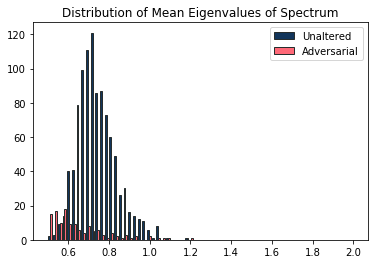

In [39]:
plt.hist([some_mean_eigs[:,0], adv_some_mean_eigs[:,0]], range=[0.5,2], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Mean Eigenvalues of Spectrum')

Text(0.5, 1.0, 'Distribution of Median Eigenvalues of Spectrum')

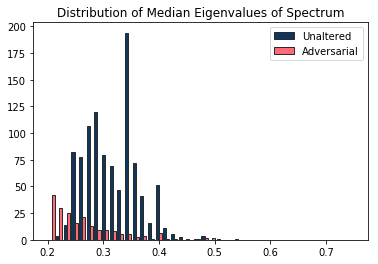

In [40]:
plt.hist([some_mean_eigs[:,2], adv_some_mean_eigs[:,2]], range=[0.2,0.75], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Median Eigenvalues of Spectrum')

Text(0.5, 1.0, 'Distribution of Spectrum Size')

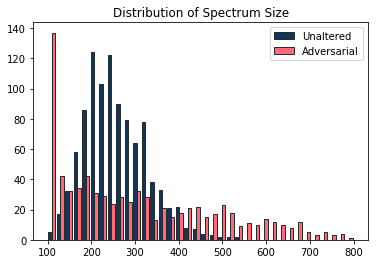

In [41]:
plt.hist([some_mean_eigs[:,1], adv_some_mean_eigs[:,1]], range=[100,800], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Spectrum Size')

Text(0.5, 1.0, 'Distribution of Minimum Eigenvalue of Spectrum')

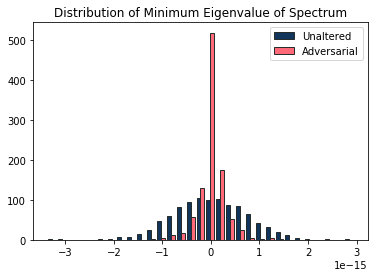

In [42]:
plt.hist([some_mean_eigs[:,3], adv_some_mean_eigs[:,3]], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Minimum Eigenvalue of Spectrum')

Text(0.5, 1.0, 'Distribution of Maximum Eigenvalue of Spectrum')

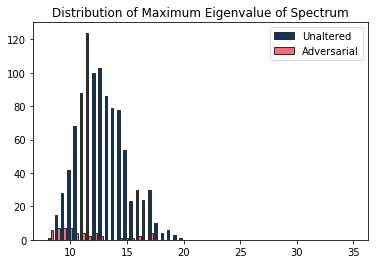

In [43]:
plt.hist([some_mean_eigs[:,4], adv_some_mean_eigs[:,4]], range=[8,35], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Maximum Eigenvalue of Spectrum')

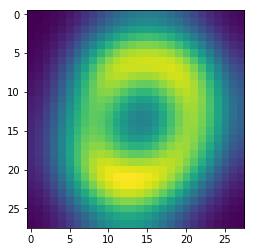

In [44]:
plt.imshow(adversaries[10]['adversary'].reshape(28,28))

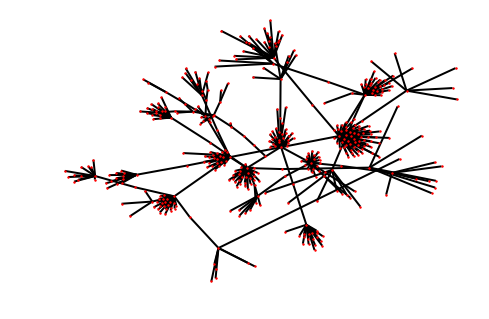

In [45]:
options = {
    'node_color': 'red',
    'node_size': 2,
    'width': 2,
    'with_labels':False}
nx.draw_spring(some_gois[2], **options)

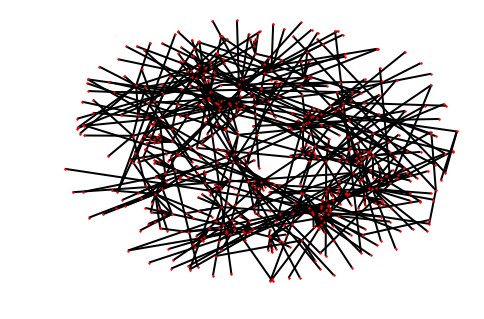

In [46]:
options = {
    'node_color': 'red',
    'node_size': 2,
    'width': 2,
    'with_labels':False}
nx.draw_spring(adv_some_gois[2], **options)

In [ ]:
weiners = np.zeros(len(all_gois))
for i in range(len(all_gois)):
    print('normal ', i)
    weiners[i] = nx.algorithms.wiener.wiener_index(all_gois[i], weight='weight')

adv_weiners = np.zeros(len(adv_all_gois))
for i in range(len(adv_all_gois)):
    print('adv ', i)
    adv_weiners[i] = nx.algorithms.wiener.wiener_index(adv_all_gois[i], weight='weight')

In [ ]:
plt.hist([weiners, adv_weiners], bins='auto')

In [ ]:
print(res_df['loss'].max())
res_df.iloc[np.where(weiners == .weiners.max())]

In [ ]:
gk = GraphKernel(kernel={"name": "multiscale_laplacian",
                             "which": "fast",
                             "L": 1,
                             "P": 10,
                             "N": 10})
# gk = grakel.RandomWalkLabeled(method_type='fast', verbose=False)

In [ ]:
for i in range(len(all_gois)):
    l = list(all_gois[i].nodes())
    for j in range(len(l)):
        all_gois[i].node[l[j]]['label'] = l[j]

In [ ]:
for i in range(len(adv_all_gois)):
    l = list(adv_all_gois[i].nodes())
    for j in range(len(l)):
        adv_all_gois[i].node[l[j]]['label'] = l[j]

In [ ]:
G_adv = grakel.graph_from_networkx(adv_all_gois, node_labels_tag='label', edge_weight_tag='weight')
G = grakel.graph_from_networkx(all_gois, node_labels_tag='label', edge_weight_tag='weight')

In [ ]:
K_train = gk.fit_transform(G)